# Galassify

## Aplicación de Deep autoencoder para segmentación con dataset v3-3k3


En este notebook repetiremos en 25 ocasiones el autoencoder, emitiendo los outliers resultantes de dos métodos:

- Mayor mse
- DBSCAN

El objetivo es comprobar como afecta la aleatoriedad a la repetición de los outliers.


### Importación de librerías y carga de datos

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.spatial import distance
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN 
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.externals import joblib

from keras.layers import Input, Dense, Activation
from keras.models import Model, Sequential, load_model
from keras import optimizers

%matplotlib inline
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

from IPython.display import Image
from IPython.core.display import HTML 

/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


En este caso, cargamos directamente los datasets original y el dataset sin negativos, creados en notebooks anteriores

In [2]:
data_origen = pd.read_csv("./data/datasetV3_3KRandom.csv", sep=";")
data_origen.head()

,PLATE,MJD,FIBER,Z,3868.645565753641,3869.535542582065,3870.4278489317717,3871.318235772099,3872.2109532069176,3873.1017502480395,3873.992752215851,3874.8860863882537,3875.777498840249,3876.671244571283,3877.563067696571,3878.45722517584,3879.3494591636186,3880.2440285808143,3881.136673620369,3882.029524011743,3882.924711445972,3883.8179731730975,3884.713573019754,3885.6072462721336,3886.503258721214,3887.3973436884376,3888.291634338733,3889.188265801773,3890.082968451347,3890.980012992077,3891.8751278307373,3892.772585639461,3893.668112857104,3894.5638460896052,3895.461923910823,3896.3580698071996,3897.2565613724432,3898.15312012281,3899.052025622691,3899.9489974172493,3900.8461755589897,3901.745702071507,3902.643293542793,3903.543234466747,3904.4412394579995,3905.3415949843097,3906.2400136860347,3907.1386390678003,3908.039616608505,3908.9386559865584,...,7417.524757252301,7419.2311490749735,7420.942007391534,7422.649185348109,7424.356756038729,7426.068796308937,7427.777153676565,7429.489982682914,7431.199127089972,7432.91274519583,7434.622677004906,7436.333002181546,7438.047804147664,7439.758917270303,7441.474509244873,7443.186410676516,7444.902793023495,7446.615483127316,7448.328567233246,7450.0461353501705,7451.760008673134,7453.478368072875,7455.1930309764675,7456.9121820235705,7458.627634871548,7460.3434823572,7462.063821087017,7463.78045906279,7465.501590351842,7467.219019181919,7468.940943395341,7470.659163444065,7472.377778767054,7474.100892579042,7475.820299667295,7477.544207317,7479.264406535282,7480.989108388424,7482.710100101674,7484.431487726802,7486.157381097453,7487.879561765048,7489.606250253956,7491.329224329366,7493.0567083028445,7494.7804761515945,7496.504640550872,7498.233317963899,7499.958276684899,7501.6877504987915
0,2099,53469,148,0.077807,0.636552,0.367806,0.278396,0.285307,0.183786,0.328635,0.450617,0.433929,0.899009,0.643836,0.475315,0.438675,0.467904,0.417998,0.323266,0.554133,0.877506,0.547206,0.296718,0.674742,0.606375,0.222630,0.451282,0.314469,0.190128,0.553508,0.495501,0.428374,1.490322,0.988478,0.554287,0.655043,0.784162,0.499813,0.408123,0.484755,0.473120,0.623950,0.716056,0.306379,0.408779,0.382334,0.384830,0.556806,0.535645,0.374631,...,1.403149,1.300737,0.854908,1.036072,1.284790,1.174821,1.219686,1.320632,1.182485,1.149967,1.135212,1.197466,1.170419,1.177966,1.258235,1.338014,0.992609,1.281974,1.229110,1.421697,1.077822,1.240584,1.259480,1.368396,0.990141,1.229603,1.239413,1.142440,1.154854,1.272670,1.196519,1.218197,1.355392,1.242389,1.247098,1.202379,0.861311,1.392254,1.273615,1.089576,1.155214,1.211078,1.142575,1.233846,1.084954,1.169770,1.161821,1.160405,1.275585,1.238802
1,1815,53884,1,0.091045,0.924821,0.955832,0.954143,0.935017,0.832751,0.854249,0.846123,0.740990,0.776660,0.833628,0.880842,0.866295,0.799464,0.879522,0.877655,0.809836,0.658508,0.459713,0.461437,0.597803,0.624169,0.539646,0.642504,0.783469,0.816040,0.770628,0.738639,0.680130,0.671148,0.666353,0.646091,0.744776,0.752563,0.641500,0.638825,0.777697,0.875334,0.836110,0.780308,0.769351,0.740468,0.693389,0.687770,0.675530,0.765399,0.892660,...,0.779851,0.728282,0.705656,0.796199,0.861313,0.789964,0.813254,0.877838,0.832707,0.821114,0.850069,0.809483,0.786298,0.802253,0.844928,0.827333,0.783233,0.829814,0.783733,0.794661,0.810325,0.747440,0.753007,0.828389,0.864708,0.812884,0.745643,0.751192,0.838403,0.857025,0.785440,0.767616,0.743195,0.724839,0.805945,0.840591,0.810032,0.829138,0.850290,0.763131,0.688105,0.779044,0.817667,0.815495,0.831063,0.807701,0.825111,0.779291,0.775595,0.852922
2,699,52202,92,0.043789,1.258258,1.268783,1.352357,1.341881,1.336860,1.250001,0.957059,0.828157,1.033551,1.245475,1.137744,0.829527,0.732822,0.620484,0.690629,0.910615,0.772459,0.725904,0.839652,0.876705,0.870031,0.748934,0.776170,0.772296,0.753819,0.862681,0.692442,0.552839,0.605622,0.583866,0.573163,0.866969,1.023563,1.088780,1.152049,0.842883,0.891214,1.112096,1.002524,1.031562,1.042673,0.982164,1.165057,0.973574,0.939535,1.107953,...,0.7

In [3]:
data = pd.read_csv("./espectros_3k_sin_negativos.csv")
data.head()

,3868.645565753641,3869.535542582065,3870.4278489317717,3871.318235772099,3872.2109532069176,3873.1017502480395,3873.992752215851,3874.8860863882537,3875.777498840249,3876.671244571283,3877.563067696571,3878.45722517584,3879.3494591636186,3880.2440285808143,3881.136673620369,3882.029524011743,3882.924711445972,3883.8179731730975,3884.713573019754,3885.6072462721336,3886.503258721214,3887.3973436884376,3888.291634338733,3889.188265801773,3890.082968451347,3890.980012992077,3891.8751278307373,3892.772585639461,3893.668112857104,3894.5638460896052,3895.461923910823,3896.3580698071996,3897.2565613724432,3898.15312012281,3899.052025622691,3899.9489974172493,3900.8461755589897,3901.745702071507,3902.643293542793,3903.543234466747,3904.4412394579995,3905.3415949843097,3906.2400136860347,3907.1386390678003,3908.039616608505,3908.9386559865584,3909.8400486071882,3910.7395021722573,3911.6413100640398,3912.541178006939,...,7417.524757252301,7419.2311490749735,7420.942007391534,7422.649185348109,7424.356756038729,7426.068796308937,7427.777153676565,7429.489982682914,7431.199127089972,7432.91274519583,7434.622677004906,7436.333002181546,7438.047804147664,7439.758917270303,7441.474509244873,7443.186410676516,7444.902793023495,7446.615483127316,7448.328567233246,7450.0461353501705,7451.760008673134,7453.478368072875,7455.1930309764675,7456.9121820235705,7458.627634871548,7460.3434823572,7462.063821087017,7463.78045906279,7465.501590351842,7467.219019181919,7468.940943395341,7470.659163444065,7472.377778767054,7474.100892579042,7475.820299667295,7477.544207317,7479.264406535282,7480.989108388424,7482.710100101674,7484.431487726802,7486.157381097453,7487.879561765048,7489.606250253956,7491.329224329366,7493.0567083028445,7494.7804761515945,7496.504640550872,7498.233317963899,7499.958276684899,7501.6877504987915
0,0.924821,0.955832,0.954143,0.935017,0.832751,0.854249,0.846123,0.740990,0.776660,0.833628,0.880842,0.866295,0.799464,0.879522,0.877655,0.809836,0.658508,0.459713,0.461437,0.597803,0.624169,0.539646,0.642504,0.783469,0.816040,0.770628,0.738639,0.680130,0.671148,0.666353,0.646091,0.744776,0.752563,0.641500,0.638825,0.777697,0.875334,0.836110,0.780308,0.769351,0.740468,0.693389,0.687770,0.675530,0.765399,0.892660,0.813037,0.865628,0.984975,0.975004,...,0.779851,0.728282,0.705656,0.796199,0.861313,0.789964,0.813254,0.877838,0.832707,0.821114,0.850069,0.809483,0.786298,0.802253,0.844928,0.827333,0.783233,0.829814,0.783733,0.794661,0.810325,0.747440,0.753007,0.828389,0.864708,0.812884,0.745643,0.751192,0.838403,0.857025,0.785440,0.767616,0.743195,0.724839,0.805945,0.840591,0.810032,0.829138,0.850290,0.763131,0.688105,0.779044,0.817667,0.815495,0.831063,0.807701,0.825111,0.779291,0.775595,0.852922
1,1.258258,1.268783,1.352357,1.341881,1.336860,1.250001,0.957059,0.828157,1.033551,1.245475,1.137744,0.829527,0.732822,0.620484,0.690629,0.910615,0.772459,0.725904,0.839652,0.876705,0.870031,0.748934,0.776170,0.772296,0.753819,0.862681,0.692442,0.552839,0.605622,0.583866,0.573163,0.866969,1.023563,1.088780,1.152049,0.842883,0.891214,1.112096,1.002524,1.031562,1.042673,0.982164,1.165057,0.973574,0.939535,1.107953,0.978757,1.160724,1.187305,0.925614,...,0.730175,0.699556,0.673700,0.662072,0.653056,0.636839,0.720679,0.643880,0.542382,0.667748,0.728863,0.591511,0.588671,0.623791,0.604367,0.717579,0.716184,0.728600,0.809191,0.835630,0.755814,0.748969,0.790636,0.735746,0.718552,0.750787,0.777957,0.748585,0.683396,0.681842,0.849851,0.857925,0.773472,0.670337,0.628301,0.721224,0.707150,0.783355,0.727580,0.692765,0.762835,0.709300,0.659228,0.652220,0.759352,0.837513,0.744902,0.661489,0.674855,0.678003
2,1.080315,1.054255,1.186841,1.184086,1.049520,1.030066,1.138974,1.196202,0.992778,0.916529,1.080038,1.004420,0.986589,1.058829,0.970565,0.952958,0.982420,0.909557,0.850695,0.847845,0.961395,0.866690,0.829688,1.085925,1.097143,0.914356,0.840732,0.813613,0.687617,0.757528,0.818865,0.826454,0.893545,0.869621,0.924727,0.973604,0.889258,0.854609,0.949721,0.908795,

Para luego entrenar los modelos y tener un set de test para las medidas de accuracy, dividimos el dataset en train y test (nos vale un 15% para el test). Recordemos que estamos usando un aprendizaje no supervisado y no tenemos etiquetas.

In [4]:
espectros_train, espectros_test = train_test_split(data, test_size=0.15, random_state=21)

Ahora podemos seguir con el proceso, primero estandarizando el dataset

In [5]:
scaler = MinMaxScaler() # = np.array(data.apply(lambda x: (x-x.min()) / (x.max()-x.min())))
#scaler.fit(espectros_train)

# Grabamos el modelo de escalado para predicciones posteriores
#joblib.dump(scaler, "./scaler.save") 

espectros_train_scaled = pd.DataFrame(scaler.fit_transform(espectros_train), 
                               columns=espectros_train.columns,
                               index=espectros_train.index)
espectros_test_scaled = pd.DataFrame(scaler.transform(espectros_test),
                             columns=espectros_test.columns,
                             index=espectros_test.index)

# Esta es la versiós estandarizada de todo el dataset para comparaciones posteriores
espectros_scaled = pd.DataFrame(scaler.transform(data), 
                               columns=data.columns,
                               index=data.index)
espectros_train_scaled.head()

,3868.645565753641,3869.535542582065,3870.4278489317717,3871.318235772099,3872.2109532069176,3873.1017502480395,3873.992752215851,3874.8860863882537,3875.777498840249,3876.671244571283,3877.563067696571,3878.45722517584,3879.3494591636186,3880.2440285808143,3881.136673620369,3882.029524011743,3882.924711445972,3883.8179731730975,3884.713573019754,3885.6072462721336,3886.503258721214,3887.3973436884376,3888.291634338733,3889.188265801773,3890.082968451347,3890.980012992077,3891.8751278307373,3892.772585639461,3893.668112857104,3894.5638460896052,3895.461923910823,3896.3580698071996,3897.2565613724432,3898.15312012281,3899.052025622691,3899.9489974172493,3900.8461755589897,3901.745702071507,3902.643293542793,3903.543234466747,3904.4412394579995,3905.3415949843097,3906.2400136860347,3907.1386390678003,3908.039616608505,3908.9386559865584,3909.8400486071882,3910.7395021722573,3911.6413100640398,3912.541178006939,...,7417.524757252301,7419.2311490749735,7420.942007391534,7422.649185348109,7424.356756038729,7426.068796308937,7427.777153676565,7429.489982682914,7431.199127089972,7432.91274519583,7434.622677004906,7436.333002181546,7438.047804147664,7439.758917270303,7441.474509244873,7443.186410676516,7444.902793023495,7446.615483127316,7448.328567233246,7450.0461353501705,7451.760008673134,7453.478368072875,7455.1930309764675,7456.9121820235705,7458.627634871548,7460.3434823572,7462.063821087017,7463.78045906279,7465.501590351842,7467.219019181919,7468.940943395341,7470.659163444065,7472.377778767054,7474.100892579042,7475.820299667295,7477.544207317,7479.264406535282,7480.989108388424,7482.710100101674,7484.431487726802,7486.157381097453,7487.879561765048,7489.606250253956,7491.329224329366,7493.0567083028445,7494.7804761515945,7496.504640550872,7498.233317963899,7499.958276684899,7501.6877504987915
1487,0.046789,0.053604,0.055648,0.080071,0.121130,0.216539,0.318437,0.284345,0.345497,0.396465,0.344769,0.438116,0.598727,0.403784,0.356447,0.459577,0.469086,0.557151,0.471794,0.226492,0.392723,0.250423,0.113744,0.076077,0.080701,0.084587,0.117633,0.182735,0.287744,0.458418,0.533045,0.469539,0.498085,0.615630,0.358033,0.358999,0.549446,0.599964,0.593810,0.502660,0.384618,0.239918,0.341655,0.372254,0.358556,0.354970,0.380826,0.519923,0.354099,0.361987,...,0.531867,0.482286,0.477126,0.070418,0.065869,0.512488,0.506550,0.477721,0.491378,0.457439,0.463949,0.464158,0.442872,0.487769,0.596765,0.536143,0.473418,0.478010,0.431326,0.416410,0.420971,0.534154,0.511030,0.433780,0.451893,0.389967,0.328177,0.378372,0.351579,0.454101,0.488400,0.438267,0.377863,0.373708,0.533289,0.556049,0.473406,0.428186,0.555424,0.557981,0.512700,0.507169,0.499952,0.414590,0.487712,0.431579,0.265097,0.412881,0.386192,0.444350
286,0.042870,0.043194,0.040441,0.070471,0.121483,0.204035,0.310615,0.360696,0.359998,0.363964,0.362744,0.308321,0.308385,0.295374,0.328696,0.321506,0.312175,0.329325,0.342449,0.218515,0.236047,0.167798,0.105088,0.082040,0.072186,0.069745,0.133349,0.249583,0.357011,0.382920,0.398235,0.380555,0.311642,0.394074,0.345389,0.436592,0.569323,0.514942,0.463700,0.414900,0.414833,0.319772,0.350983,0.371539,0.406099,0.421870,0.338141,0.366055,0.359663,0.416483,...,0.402116,0.362634,0.408587,0.054448,0.052285,0.384441,0.399613,0.380611,0.370467,0.350166,0.403168,0.436607,0.404004,0.337816,0.356093,0.400222,0.402566,0.385212,0.370289,0.403246,0.396054,0.446627,0.388011,0.365608,0.419906,0.355603,0.293788,0.328324,0.336637,0.444402,0.433791,0.413267,0.371199,0.329037,0.399887,0.448658,0.394951,0.318598,0.391062,0.464890,0.412668,0.382635,0.368748,0.325613,0.417306,0.366023,0.248229,0.407445,0.363731,0.359450
2412,0.064810,0.064128,0.061764,0.088989,0.159838,0.342942,0.580944,0.519090,0.484695,0.488673,0.531886,0.571345,0.621236,0.540134,0.448696,0.386385,0.462894,0.529105,0.515576,0.330347,0.293290,0.200233,0.132326,0.109068,0.106123,0.102665,0.153158,0.278523,0.444874,0.611983,0.572783,0.465074,0.422568,0.568527,0.544041,0.589858,0.589696,0.469399,0.596358,0

In [6]:
# Función para entrenar los dos modelos requeriodos: el autoencoder, que es el modelo completo, y el encoder, que
# general el espectro latente. Tiene bastantes posibilidades de configuración para automatizar procesos
# - entrada: el dataset de entrada, ya escalado
# - dim latente, el número de dimensiones del espacio latente. Por defecto 250
# - epochs - ciclos del entrenamiento, 125 por defecto
# - lr - learning rate. El optimizador será Adadelta, por lo que irá reduciéndose de forma adaptativa
#        con un factor rho de 0.95
# - grabar, por se deseamos grabar los modelos resultantes en un archivo h5 o no
# - cargar, por si deseamos cargar un modelo grabado previamente en archivo h5 o no (si cargamos, el modelo no
#        se entrenará).
# - Si hemos dado a grabar o a cargar el valor True, hay que especificar el nombre de los archivos h5 para ambos
#        modelor (autoencoder y encoder)
# - grafica, por si deseamos imprimir la gráfica de errores durante el entrenamiento o no
def autoencoder(entrada, dim_latente = 250, epochs = 125, lr = 0.30,
                grabar = False, cargar = False, archivo_encoder = " ", archivo_autoencoder = " ", grafica = False):

    if cargar:
        encoder = load_model(archivo_encoder)
        autoencoder_deep = load_model(archivo_autoencoder)
    else:    
        dim_input = entrada.shape[1]
        adadelta = optimizers.Adadelta(lr=lr, rho=0.95)

        input = Input(shape=((dim_input, )))
        encoded = Dense(2000, activation='selu')(input)
        encoded = Dense(1000, activation='selu')(encoded)
        encoded = Dense(dim_latente, activation='selu')(encoded)
        decoded = Dense(1000, activation='selu')(encoded)
        decoded = Dense(2000, activation='selu')(decoded)
        decoded = Dense(dim_input, activation='sigmoid')(decoded)

        autoencoder_deep = Model(input, decoded)
        encoder = Model(input, encoded)
    
        autoencoder_deep.compile(optimizer=adadelta, loss='binary_crossentropy', metrics=["accuracy"])
        autoencoder_deep.fit(espectros_train_scaled, espectros_train_scaled,
                epochs=epochs,
                batch_size=256,
                shuffle=True,
                validation_data=(espectros_test_scaled, espectros_test_scaled))  
        if grafica:
            grafica_loss(autoencoder_deep, epochs)
        if grabar:
            autoencoder_deep.save(archivo_autoencoder)
            encoder.save(archivo_encoder)
    
    return encoder, autoencoder_deep

In [7]:
# Dibujaremos el espectro de entrada, el de salida y el error entre ambos
# - original es el dataset de espectros de entrada
# - salida es la matriz np con los espectros de salida del autoencoder
def grafica_error(original, salida, i):
    plt.figure(figsize=(20, 10))
    original.iloc[i].plot();
    plt.ylim(top=1, bottom=0);
    plt.figure(figsize=(20, 10))
    plt.plot(salida[i]);
    plt.ylim(top=1, bottom=0);
    plt.xlim(left=0, right=len(espectros_salida[i]));
    plt.figure(figsize=(20,5))
    plt.ylim(top=1, bottom=-1);
    (entrada.iloc[i]-salida[i]).plot();

In [8]:
# Función par agraficar el espectro original completo, así como los detalles de las bandas (6480, 6650) y
# (4800, 5050)
def grafOutlier(dataset, cluster, orden, salva=False):
    filtro1 = [x for x in data_origen.columns[4:] if ((float(x) >= 6480) & (float(x) <= 6650))]
    filtro2 = [x for x in data_origen.columns[4:] if ((float(x) >= 4800) & (float(x) <= 5050))]
    #filtro3 = [x for x in data_origen.columns[4:] if ((float(x) >= 5150) & (float(x) <= 5200))]
    
    print("----------\n")
    print(data_origen.iloc[cluster[orden]][:4])
    
    plt.figure(figsize=(30, 20));
    plt.title("Espectro original", fontsize=30)
    plt.xticks(fontsize=20, rotation=90)
    plt.yticks(fontsize=20)
    data_origen[data_origen.columns[4:]].iloc[cluster[orden]].plot();
    if salva:
        nombre_archivo = "Espectro_" + str(orden) +  "_1.png"
        plt.savefig(nombre_archivo)
    plt.figure(figsize=(30, 20));
    plt.title("Detalle (6480, 6650)", fontsize=30)
    plt.xticks(fontsize=20, rotation=90)
    plt.yticks(fontsize=20)
    data_origen.filter(filtro1, axis=1).iloc[cluster[orden]].plot();
    if salva:
        nombre_archivo = "Espectro_" + str(orden) +  "_2.png"
        plt.savefig(nombre_archivo)
    plt.figure(figsize=(30, 20));
    plt.title("Detalle (4800, 5050)", fontsize=30)
    plt.xticks(fontsize=15, rotation=90)
    plt.yticks(fontsize=20)
    data_origen.filter(filtro2, axis=1).iloc[cluster[orden]].plot();
    if salva:
        nombre_archivo = "Espectro_" + str(orden) +  "_3.png"
        plt.savefig(nombre_archivo)


Ahora vamos a repetir 25 veces el proceso de entrenar el autoencoder, generar los outliers con el procedimiento de máximo error mse y con el procedimiento con DBSCAN.

Después analizaremos cuantas veces se repiten los outliers en esas repeticiones por cada método y cuantos outliers se repiten en ambos métodos.

In [9]:
repeticiones = 25
outliers_mse = []
outliers_dbscan = []
for i in range(repeticiones):
    print("Repetición: ", i)
    encoder_model, autoencoder_model = autoencoder(entrada=espectros_train_scaled)
    espectros_latentes = encoder_model.predict(espectros_scaled)
    espectros_salida = autoencoder_model.predict(espectros_scaled)

    # Outliers metodo 1
    mse = np.mean(np.power(espectros_scaled - espectros_salida, 2), axis=1)
    df_error = pd.DataFrame({'error': mse}, index=espectros_scaled.index)
    print(df_error.index[df_error["error"] > 0.02].tolist())
    outliers_mse.append(df_error.index[df_error["error"] > 0.02].tolist())
    
    # Outliers método 2
    clustering = DBSCAN(eps=3.5, min_samples=2, n_jobs=-1).fit(espectros_latentes)
    labels_DBSCAN = np.unique(clustering.labels_, return_counts=True)
    clusters_DBSCAN = []
    for i in range(-1,len(labels_DBSCAN[0]), 1): # Empezamos en -1 para coger los outliers, en el índice 0 del array labels
        clusters_DBSCAN.append(np.where(clustering.labels_==i))
    print(clusters_DBSCAN[0][0].tolist())
    outliers_dbscan.append(clusters_DBSCAN[0][0].tolist())
    

W0830 08:15:34.581992 139744623822656 deprecation_wrapper.py:119] From /home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0830 08:15:34.583272 139744623822656 deprecation_wrapper.py:119] From /home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0830 08:15:34.586506 139744623822656 deprecation_wrapper.py:119] From /home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0830 08:15:34.604121 139744623822656 deprecation.py:323] From /home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3217: add_dispatch_support.<locals>.wr

Repetición:  0


W0830 08:15:35.102107 139744623822656 deprecation_wrapper.py:119] From /home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 2149 samples, validate on 380 samples
Epoch 1/125
2149/2149 [==============================] - 5s 2ms/step - loss: 0.6991 - acc: 4.6808e-04 - val_loss: 0.6890 - val_acc: 0.0000e+00
Epoch 2/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6836 - acc: 4.8976e-04 - val_loss: 0.6761 - val_acc: 0.0000e+00
Epoch 3/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6720 - acc: 5.0156e-04 - val_loss: 0.6667 - val_acc: 0.0000e+00
Epoch 4/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6634 - acc: 5.0512e-04 - val_loss: 0.6590 - val_acc: 0.0000e+00
Epoch 5/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6564 - acc: 5.0803e-04 - val_loss: 0.6531 - val_acc: 0.0000e+00
Epoch 6/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6511 - acc: 5.1774e-04 - val_loss: 0.6487 - val_acc: 0.0000e+00
Epoch 7/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6473 - acc: 5.19

2149/2149 [==============================] - 3s 1ms/step - loss: 0.6258 - acc: 7.0601e-04 - val_loss: 0.6250 - val_acc: 0.0000e+00
Epoch 58/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6257 - acc: 7.0568e-04 - val_loss: 0.6249 - val_acc: 0.0000e+00
Epoch 59/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6257 - acc: 7.0633e-04 - val_loss: 0.6249 - val_acc: 0.0000e+00
Epoch 60/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6257 - acc: 7.0601e-04 - val_loss: 0.6249 - val_acc: 0.0000e+00
Epoch 61/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6257 - acc: 7.0649e-04 - val_loss: 0.6248 - val_acc: 0.0000e+00
Epoch 62/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6256 - acc: 7.0681e-04 - val_loss: 0.6248 - val_acc: 0.0000e+00
Epoch 63/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6256 - acc: 7.0584e-04 - val_loss: 0.6248 - val_acc: 0.0000e+00
Epoch

Epoch 114/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1183e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
Epoch 115/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1150e-04 - val_loss: 0.6241 - val_acc: 0.0000e+00
Epoch 116/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1167e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
Epoch 117/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1199e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
Epoch 118/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6253 - acc: 7.1248e-04 - val_loss: 0.6243 - val_acc: 0.0000e+00
Epoch 119/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6253 - acc: 7.1215e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
Epoch 120/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6253 - acc: 7.1167e-04 - val_loss: 0.6243 - val_a

2149/2149 [==============================] - 3s 1ms/step - loss: 0.6267 - acc: 7.0212e-04 - val_loss: 0.6261 - val_acc: 0.0000e+00
Epoch 45/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6266 - acc: 7.0212e-04 - val_loss: 0.6259 - val_acc: 0.0000e+00
Epoch 46/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6265 - acc: 7.0245e-04 - val_loss: 0.6258 - val_acc: 0.0000e+00
Epoch 47/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6265 - acc: 7.0309e-04 - val_loss: 0.6257 - val_acc: 0.0000e+00
Epoch 48/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6264 - acc: 7.0293e-04 - val_loss: 0.6257 - val_acc: 0.0000e+00
Epoch 49/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6263 - acc: 7.0406e-04 - val_loss: 0.6256 - val_acc: 0.0000e+00
Epoch 50/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6262 - acc: 7.0423e-04 - val_loss: 0.6255 - val_acc: 0.0000e+00
Epoch

Epoch 101/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6253 - acc: 7.1377e-04 - val_loss: 0.6243 - val_acc: 0.0000e+00
Epoch 102/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1377e-04 - val_loss: 0.6243 - val_acc: 0.0000e+00
Epoch 103/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1345e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
Epoch 104/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1393e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
Epoch 105/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1458e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
Epoch 106/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1393e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
Epoch 107/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1458e-04 - val_loss: 0.6242 - val_a

2149/2149 [==============================] - 3s 1ms/step - loss: 0.6288 - acc: 6.8401e-04 - val_loss: 0.6282 - val_acc: 0.0000e+00
Epoch 32/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6285 - acc: 6.8676e-04 - val_loss: 0.6279 - val_acc: 0.0000e+00
Epoch 33/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6282 - acc: 6.8935e-04 - val_loss: 0.6276 - val_acc: 0.0000e+00
Epoch 34/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6280 - acc: 6.9096e-04 - val_loss: 0.6273 - val_acc: 0.0000e+00
Epoch 35/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6277 - acc: 6.9323e-04 - val_loss: 0.6271 - val_acc: 0.0000e+00
Epoch 36/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6275 - acc: 6.9436e-04 - val_loss: 0.6269 - val_acc: 0.0000e+00
Epoch 37/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6274 - acc: 6.9549e-04 - val_loss: 0.6267 - val_acc: 0.0000e+00
Epoch

Epoch 88/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6254 - acc: 7.1264e-04 - val_loss: 0.6244 - val_acc: 0.0000e+00
Epoch 89/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6253 - acc: 7.1248e-04 - val_loss: 0.6244 - val_acc: 0.0000e+00
Epoch 90/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6253 - acc: 7.1296e-04 - val_loss: 0.6244 - val_acc: 0.0000e+00
Epoch 91/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6253 - acc: 7.1248e-04 - val_loss: 0.6243 - val_acc: 0.0000e+00
Epoch 92/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6253 - acc: 7.1296e-04 - val_loss: 0.6243 - val_acc: 0.0000e+00
Epoch 93/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6253 - acc: 7.1280e-04 - val_loss: 0.6243 - val_acc: 0.0000e+00
Epoch 94/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6253 - acc: 7.1361e-04 - val_loss: 0.6243 - val_acc: 0.0

2149/2149 [==============================] - 3s 1ms/step - loss: 0.6360 - acc: 5.9489e-04 - val_loss: 0.6354 - val_acc: 0.0000e+00
Epoch 19/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6353 - acc: 6.0330e-04 - val_loss: 0.6347 - val_acc: 0.0000e+00
Epoch 20/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6346 - acc: 6.1203e-04 - val_loss: 0.6339 - val_acc: 0.0000e+00
Epoch 21/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6339 - acc: 6.2190e-04 - val_loss: 0.6333 - val_acc: 0.0000e+00
Epoch 22/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6333 - acc: 6.2982e-04 - val_loss: 0.6326 - val_acc: 0.0000e+00
Epoch 23/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6327 - acc: 6.3888e-04 - val_loss: 0.6320 - val_acc: 0.0000e+00
Epoch 24/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6321 - acc: 6.4341e-04 - val_loss: 0.6314 - val_acc: 0.0000e+00
Epoch

Epoch 75/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6254 - acc: 7.0649e-04 - val_loss: 0.6245 - val_acc: 0.0000e+00
Epoch 76/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6254 - acc: 7.0665e-04 - val_loss: 0.6244 - val_acc: 0.0000e+00
Epoch 77/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6254 - acc: 7.0665e-04 - val_loss: 0.6244 - val_acc: 0.0000e+00
Epoch 78/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6254 - acc: 7.0746e-04 - val_loss: 0.6244 - val_acc: 0.0000e+00
Epoch 79/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6254 - acc: 7.0698e-04 - val_loss: 0.6244 - val_acc: 0.0000e+00
Epoch 80/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6254 - acc: 7.0714e-04 - val_loss: 0.6244 - val_acc: 0.0000e+00
Epoch 81/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6254 - acc: 7.0762e-04 - val_loss: 0.6244 - val_acc: 0.0

2149/2149 [==============================] - 3s 1ms/step - loss: 0.6578 - acc: 4.9849e-04 - val_loss: 0.6544 - val_acc: 0.0000e+00
Epoch 6/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6523 - acc: 5.0415e-04 - val_loss: 0.6498 - val_acc: 0.0000e+00
Epoch 7/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6482 - acc: 5.0771e-04 - val_loss: 0.6464 - val_acc: 0.0000e+00
Epoch 8/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6453 - acc: 5.1353e-04 - val_loss: 0.6441 - val_acc: 0.0000e+00
Epoch 9/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6433 - acc: 5.2275e-04 - val_loss: 0.6424 - val_acc: 0.0000e+00
Epoch 10/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6418 - acc: 5.3262e-04 - val_loss: 0.6411 - val_acc: 0.0000e+00
Epoch 11/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6406 - acc: 5.3925e-04 - val_loss: 0.6400 - val_acc: 0.0000e+00
Epoch 12/

2149/2149 [==============================] - 3s 1ms/step - loss: 0.6257 - acc: 7.0924e-04 - val_loss: 0.6248 - val_acc: 0.0000e+00
Epoch 63/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6256 - acc: 7.0924e-04 - val_loss: 0.6248 - val_acc: 0.0000e+00
Epoch 64/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6256 - acc: 7.0827e-04 - val_loss: 0.6248 - val_acc: 0.0000e+00
Epoch 65/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6256 - acc: 7.0892e-04 - val_loss: 0.6247 - val_acc: 0.0000e+00
Epoch 66/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6256 - acc: 7.0940e-04 - val_loss: 0.6247 - val_acc: 0.0000e+00
Epoch 67/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6256 - acc: 7.0940e-04 - val_loss: 0.6247 - val_acc: 0.0000e+00
Epoch 68/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6256 - acc: 7.0956e-04 - val_loss: 0.6247 - val_acc: 0.0000e+00
Epoch

Epoch 119/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1296e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
Epoch 120/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1328e-04 - val_loss: 0.6241 - val_acc: 0.0000e+00
Epoch 121/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1345e-04 - val_loss: 0.6241 - val_acc: 0.0000e+00
Epoch 122/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1296e-04 - val_loss: 0.6241 - val_acc: 0.0000e+00
Epoch 123/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6251 - acc: 7.1312e-04 - val_loss: 0.6241 - val_acc: 0.0000e+00
Epoch 124/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6251 - acc: 7.1296e-04 - val_loss: 0.6241 - val_acc: 0.0000e+00
Epoch 125/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1280e-04 - val_loss: 0.6241 - val_a

2149/2149 [==============================] - 4s 2ms/step - loss: 0.6262 - acc: 7.0665e-04 - val_loss: 0.6254 - val_acc: 0.0000e+00
Epoch 50/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6261 - acc: 7.0795e-04 - val_loss: 0.6253 - val_acc: 0.0000e+00
Epoch 51/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6261 - acc: 7.0795e-04 - val_loss: 0.6253 - val_acc: 0.0000e+00
Epoch 52/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6260 - acc: 7.0746e-04 - val_loss: 0.6252 - val_acc: 0.0000e+00
Epoch 53/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6260 - acc: 7.0730e-04 - val_loss: 0.6252 - val_acc: 0.0000e+00
Epoch 54/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6259 - acc: 7.0843e-04 - val_loss: 0.6251 - val_acc: 0.0000e+00
Epoch 55/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6259 - acc: 7.0875e-04 - val_loss: 0.6251 - val_acc: 0.0000e+00
Epoch

Epoch 106/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1118e-04 - val_loss: 0.6241 - val_acc: 0.0000e+00
Epoch 107/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1102e-04 - val_loss: 0.6241 - val_acc: 0.0000e+00
Epoch 108/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1102e-04 - val_loss: 0.6241 - val_acc: 0.0000e+00
Epoch 109/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1118e-04 - val_loss: 0.6241 - val_acc: 0.0000e+00
Epoch 110/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1086e-04 - val_loss: 0.6241 - val_acc: 0.0000e+00
Epoch 111/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1086e-04 - val_loss: 0.6241 - val_acc: 0.0000e+00
Epoch 112/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1134e-04 - val_loss: 0.6241 - val_a

2149/2149 [==============================] - 3s 1ms/step - loss: 0.6274 - acc: 6.9371e-04 - val_loss: 0.6268 - val_acc: 0.0000e+00
Epoch 37/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6273 - acc: 6.9468e-04 - val_loss: 0.6266 - val_acc: 0.0000e+00
Epoch 38/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6271 - acc: 6.9549e-04 - val_loss: 0.6264 - val_acc: 0.0000e+00
Epoch 39/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6270 - acc: 6.9614e-04 - val_loss: 0.6263 - val_acc: 0.0000e+00
Epoch 40/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6268 - acc: 6.9824e-04 - val_loss: 0.6262 - val_acc: 0.0000e+00
Epoch 41/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6267 - acc: 6.9889e-04 - val_loss: 0.6260 - val_acc: 0.0000e+00
Epoch 42/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6266 - acc: 7.0034e-04 - val_loss: 0.6259 - val_acc: 0.0000e+00
Epoch

Epoch 93/125
2149/2149 [==============================] - 4s 2ms/step - loss: 0.6253 - acc: 7.1086e-04 - val_loss: 0.6243 - val_acc: 0.0000e+00
Epoch 94/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6253 - acc: 7.1102e-04 - val_loss: 0.6243 - val_acc: 0.0000e+00
Epoch 95/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6253 - acc: 7.1150e-04 - val_loss: 0.6243 - val_acc: 0.0000e+00
Epoch 96/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6253 - acc: 7.1167e-04 - val_loss: 0.6243 - val_acc: 0.0000e+00
Epoch 97/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6253 - acc: 7.1021e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
Epoch 98/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1134e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
Epoch 99/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1134e-04 - val_loss: 0.6243 - val_acc: 0.0

2149/2149 [==============================] - 3s 1ms/step - loss: 0.6323 - acc: 6.4600e-04 - val_loss: 0.6317 - val_acc: 0.0000e+00
Epoch 24/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6317 - acc: 6.5053e-04 - val_loss: 0.6311 - val_acc: 0.0000e+00
Epoch 25/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6312 - acc: 6.5781e-04 - val_loss: 0.6306 - val_acc: 0.0000e+00
Epoch 26/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6307 - acc: 6.6088e-04 - val_loss: 0.6301 - val_acc: 0.0000e+00
Epoch 27/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6302 - acc: 6.6589e-04 - val_loss: 0.6296 - val_acc: 0.0000e+00
Epoch 28/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6298 - acc: 6.7091e-04 - val_loss: 0.6292 - val_acc: 0.0000e+00
Epoch 29/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6294 - acc: 6.7592e-04 - val_loss: 0.6288 - val_acc: 0.0000e+00
Epoch

Epoch 80/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6254 - acc: 7.0956e-04 - val_loss: 0.6245 - val_acc: 0.0000e+00
Epoch 81/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6254 - acc: 7.0908e-04 - val_loss: 0.6245 - val_acc: 0.0000e+00
Epoch 82/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6254 - acc: 7.0956e-04 - val_loss: 0.6245 - val_acc: 0.0000e+00
Epoch 83/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6254 - acc: 7.0956e-04 - val_loss: 0.6245 - val_acc: 0.0000e+00
Epoch 84/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6254 - acc: 7.0940e-04 - val_loss: 0.6244 - val_acc: 0.0000e+00
Epoch 85/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6254 - acc: 7.0924e-04 - val_loss: 0.6244 - val_acc: 0.0000e+00
Epoch 86/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6254 - acc: 7.0989e-04 - val_loss: 0.6244 - val_acc: 0.0

2149/2149 [==============================] - 3s 1ms/step - loss: 0.6427 - acc: 5.1903e-04 - val_loss: 0.6420 - val_acc: 0.0000e+00
Epoch 11/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6416 - acc: 5.2388e-04 - val_loss: 0.6410 - val_acc: 0.0000e+00
Epoch 12/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6407 - acc: 5.3456e-04 - val_loss: 0.6402 - val_acc: 0.0000e+00
Epoch 13/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6399 - acc: 5.4345e-04 - val_loss: 0.6394 - val_acc: 0.0000e+00
Epoch 14/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6391 - acc: 5.5284e-04 - val_loss: 0.6387 - val_acc: 0.0000e+00
Epoch 15/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6384 - acc: 5.6351e-04 - val_loss: 0.6380 - val_acc: 0.0000e+00
Epoch 16/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6378 - acc: 5.7241e-04 - val_loss: 0.6373 - val_acc: 0.0000e+00
Epoch

Epoch 67/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6256 - acc: 7.0956e-04 - val_loss: 0.6247 - val_acc: 0.0000e+00
Epoch 68/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6256 - acc: 7.0989e-04 - val_loss: 0.6247 - val_acc: 0.0000e+00
Epoch 69/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6256 - acc: 7.1037e-04 - val_loss: 0.6247 - val_acc: 0.0000e+00
Epoch 70/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6256 - acc: 7.1005e-04 - val_loss: 0.6247 - val_acc: 0.0000e+00
Epoch 71/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6255 - acc: 7.1021e-04 - val_loss: 0.6247 - val_acc: 0.0000e+00
Epoch 72/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6255 - acc: 7.1070e-04 - val_loss: 0.6246 - val_acc: 0.0000e+00
Epoch 73/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6255 - acc: 7.1086e-04 - val_loss: 0.6246 - val_acc: 0.0

Epoch 124/125
2149/2149 [==============================] - 4s 2ms/step - loss: 0.6252 - acc: 7.1442e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
Epoch 125/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1264e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
[37, 195, 360, 521, 650, 992, 1202, 1401, 1551, 1607, 1925, 2176, 2451, 2520]
[37, 195, 360, 521, 650, 992, 1084, 1401, 1832, 1925, 2184, 2336, 2498]
Repetición:  9
Train on 2149 samples, validate on 380 samples
Epoch 1/125
2149/2149 [==============================] - 8s 4ms/step - loss: 0.7006 - acc: 4.6889e-04 - val_loss: 0.6879 - val_acc: 0.0000e+00
Epoch 2/125
2149/2149 [==============================] - 4s 2ms/step - loss: 0.6843 - acc: 4.8215e-04 - val_loss: 0.6783 - val_acc: 0.0000e+00
Epoch 3/125
2149/2149 [==============================] - 4s 2ms/step - loss: 0.6741 - acc: 4.8879e-04 - val_loss: 0.6686 - val_acc: 0.0000e+00
Epoch 4/125
2149/2149 [==============================] - 4s 2ms/step 

2149/2149 [==============================] - 3s 1ms/step - loss: 0.6260 - acc: 7.0762e-04 - val_loss: 0.6252 - val_acc: 0.0000e+00
Epoch 55/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6259 - acc: 7.0859e-04 - val_loss: 0.6251 - val_acc: 0.0000e+00
Epoch 56/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6259 - acc: 7.0827e-04 - val_loss: 0.6251 - val_acc: 0.0000e+00
Epoch 57/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6259 - acc: 7.0924e-04 - val_loss: 0.6251 - val_acc: 0.0000e+00
Epoch 58/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6258 - acc: 7.0875e-04 - val_loss: 0.6250 - val_acc: 0.0000e+00
Epoch 59/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6258 - acc: 7.0908e-04 - val_loss: 0.6250 - val_acc: 0.0000e+00
Epoch 60/125
2149/2149 [==============================] - 4s 2ms/step - loss: 0.6258 - acc: 7.0924e-04 - val_loss: 0.6249 - val_acc: 0.0000e+00
Epoch

Epoch 111/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1199e-04 - val_loss: 0.6241 - val_acc: 0.0000e+00
Epoch 112/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1215e-04 - val_loss: 0.6241 - val_acc: 0.0000e+00
Epoch 113/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1231e-04 - val_loss: 0.6241 - val_acc: 0.0000e+00
Epoch 114/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1231e-04 - val_loss: 0.6241 - val_acc: 0.0000e+00
Epoch 115/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1215e-04 - val_loss: 0.6241 - val_acc: 0.0000e+00
Epoch 116/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1231e-04 - val_loss: 0.6241 - val_acc: 0.0000e+00
Epoch 117/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1231e-04 - val_loss: 0.6241 - val_a

2149/2149 [==============================] - 3s 1ms/step - loss: 0.6269 - acc: 6.9857e-04 - val_loss: 0.6263 - val_acc: 0.0000e+00
Epoch 42/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6268 - acc: 6.9937e-04 - val_loss: 0.6261 - val_acc: 0.0000e+00
Epoch 43/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6267 - acc: 6.9905e-04 - val_loss: 0.6260 - val_acc: 0.0000e+00
Epoch 44/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6266 - acc: 7.0083e-04 - val_loss: 0.6259 - val_acc: 0.0000e+00
Epoch 45/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6265 - acc: 7.0067e-04 - val_loss: 0.6258 - val_acc: 0.0000e+00
Epoch 46/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6264 - acc: 7.0245e-04 - val_loss: 0.6257 - val_acc: 0.0000e+00
Epoch 47/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6263 - acc: 7.0293e-04 - val_loss: 0.6256 - val_acc: 0.0000e+00
Epoch

Epoch 98/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1150e-04 - val_loss: 0.6243 - val_acc: 0.0000e+00
Epoch 99/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1134e-04 - val_loss: 0.6243 - val_acc: 0.0000e+00
Epoch 100/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1150e-04 - val_loss: 0.6243 - val_acc: 0.0000e+00
Epoch 101/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1183e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
Epoch 102/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1248e-04 - val_loss: 0.6243 - val_acc: 0.0000e+00
Epoch 103/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1199e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
Epoch 104/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1231e-04 - val_loss: 0.6242 - val_acc

2149/2149 [==============================] - 3s 1ms/step - loss: 0.6301 - acc: 6.7252e-04 - val_loss: 0.6295 - val_acc: 0.0000e+00
Epoch 29/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6297 - acc: 6.7641e-04 - val_loss: 0.6291 - val_acc: 0.0000e+00
Epoch 30/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6293 - acc: 6.8174e-04 - val_loss: 0.6287 - val_acc: 0.0000e+00
Epoch 31/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6290 - acc: 6.8433e-04 - val_loss: 0.6284 - val_acc: 0.0000e+00
Epoch 32/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6287 - acc: 6.8611e-04 - val_loss: 0.6281 - val_acc: 0.0000e+00
Epoch 33/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6284 - acc: 6.8789e-04 - val_loss: 0.6278 - val_acc: 0.0000e+00
Epoch 34/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6281 - acc: 6.9015e-04 - val_loss: 0.6276 - val_acc: 0.0000e+00
Epoch

Epoch 85/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6254 - acc: 7.1248e-04 - val_loss: 0.6245 - val_acc: 0.0000e+00
Epoch 86/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6254 - acc: 7.1264e-04 - val_loss: 0.6244 - val_acc: 0.0000e+00
Epoch 87/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6253 - acc: 7.1248e-04 - val_loss: 0.6244 - val_acc: 0.0000e+00
Epoch 88/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6253 - acc: 7.1296e-04 - val_loss: 0.6244 - val_acc: 0.0000e+00
Epoch 89/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6253 - acc: 7.1215e-04 - val_loss: 0.6244 - val_acc: 0.0000e+00
Epoch 90/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6253 - acc: 7.1280e-04 - val_loss: 0.6244 - val_acc: 0.0000e+00
Epoch 91/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6253 - acc: 7.1248e-04 - val_loss: 0.6244 - val_acc: 0.0

2149/2149 [==============================] - 3s 1ms/step - loss: 0.6375 - acc: 5.7402e-04 - val_loss: 0.6370 - val_acc: 0.0000e+00
Epoch 16/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6367 - acc: 5.8260e-04 - val_loss: 0.6362 - val_acc: 0.0000e+00
Epoch 17/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6360 - acc: 5.9376e-04 - val_loss: 0.6355 - val_acc: 0.0000e+00
Epoch 18/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6353 - acc: 6.0330e-04 - val_loss: 0.6347 - val_acc: 0.0000e+00
Epoch 19/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6346 - acc: 6.1139e-04 - val_loss: 0.6340 - val_acc: 0.0000e+00
Epoch 20/125
2149/2149 [==============================] - 4s 2ms/step - loss: 0.6339 - acc: 6.2158e-04 - val_loss: 0.6333 - val_acc: 0.0000e+00
Epoch 21/125
2149/2149 [==============================] - 4s 2ms/step - loss: 0.6333 - acc: 6.2885e-04 - val_loss: 0.6327 - val_acc: 0.0000e+00
Epoch

Epoch 72/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6255 - acc: 7.1037e-04 - val_loss: 0.6246 - val_acc: 0.0000e+00
Epoch 73/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6255 - acc: 7.1021e-04 - val_loss: 0.6246 - val_acc: 0.0000e+00
Epoch 74/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6255 - acc: 7.1021e-04 - val_loss: 0.6245 - val_acc: 0.0000e+00
Epoch 75/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6255 - acc: 7.0956e-04 - val_loss: 0.6245 - val_acc: 0.0000e+00
Epoch 76/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6254 - acc: 7.1021e-04 - val_loss: 0.6245 - val_acc: 0.0000e+00
Epoch 77/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6254 - acc: 7.1005e-04 - val_loss: 0.6245 - val_acc: 0.0000e+00
Epoch 78/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6254 - acc: 7.0989e-04 - val_loss: 0.6245 - val_acc: 0.0

2149/2149 [==============================] - 3s 1ms/step - loss: 0.6838 - acc: 4.8636e-04 - val_loss: 0.6771 - val_acc: 0.0000e+00
Epoch 3/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6728 - acc: 4.9574e-04 - val_loss: 0.6672 - val_acc: 0.0000e+00
Epoch 4/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6639 - acc: 5.0043e-04 - val_loss: 0.6595 - val_acc: 0.0000e+00
Epoch 5/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6570 - acc: 5.0706e-04 - val_loss: 0.6537 - val_acc: 0.0000e+00
Epoch 6/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6518 - acc: 5.0771e-04 - val_loss: 0.6494 - val_acc: 0.0000e+00
Epoch 7/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6481 - acc: 5.0755e-04 - val_loss: 0.6464 - val_acc: 0.0000e+00
Epoch 8/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6455 - acc: 5.1191e-04 - val_loss: 0.6443 - val_acc: 0.0000e+00
Epoch 9/125

2149/2149 [==============================] - 4s 2ms/step - loss: 0.6258 - acc: 7.0568e-04 - val_loss: 0.6250 - val_acc: 0.0000e+00
Epoch 60/125
2149/2149 [==============================] - 4s 2ms/step - loss: 0.6258 - acc: 7.0487e-04 - val_loss: 0.6249 - val_acc: 0.0000e+00
Epoch 61/125
2149/2149 [==============================] - 4s 2ms/step - loss: 0.6257 - acc: 7.0584e-04 - val_loss: 0.6249 - val_acc: 0.0000e+00
Epoch 62/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6257 - acc: 7.0568e-04 - val_loss: 0.6248 - val_acc: 0.0000e+00
Epoch 63/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6257 - acc: 7.0649e-04 - val_loss: 0.6248 - val_acc: 0.0000e+00
Epoch 64/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6257 - acc: 7.0681e-04 - val_loss: 0.6248 - val_acc: 0.0000e+00
Epoch 65/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6256 - acc: 7.0714e-04 - val_loss: 0.6247 - val_acc: 0.0000e+00
Epoch

Epoch 116/125
2149/2149 [==============================] - 4s 2ms/step - loss: 0.6252 - acc: 7.1167e-04 - val_loss: 0.6241 - val_acc: 0.0000e+00
Epoch 117/125
2149/2149 [==============================] - 4s 2ms/step - loss: 0.6252 - acc: 7.1248e-04 - val_loss: 0.6241 - val_acc: 0.0000e+00
Epoch 118/125
2149/2149 [==============================] - 4s 2ms/step - loss: 0.6251 - acc: 7.1248e-04 - val_loss: 0.6241 - val_acc: 0.0000e+00
Epoch 119/125
2149/2149 [==============================] - 4s 2ms/step - loss: 0.6251 - acc: 7.1248e-04 - val_loss: 0.6241 - val_acc: 0.0000e+00
Epoch 120/125
2149/2149 [==============================] - 3s 2ms/step - loss: 0.6251 - acc: 7.1312e-04 - val_loss: 0.6241 - val_acc: 0.0000e+00
Epoch 121/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1167e-04 - val_loss: 0.6241 - val_acc: 0.0000e+00
Epoch 122/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6251 - acc: 7.1167e-04 - val_loss: 0.6240 - val_a

2149/2149 [==============================] - 3s 1ms/step - loss: 0.6263 - acc: 7.0293e-04 - val_loss: 0.6256 - val_acc: 0.0000e+00
Epoch 47/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6262 - acc: 7.0342e-04 - val_loss: 0.6255 - val_acc: 0.0000e+00
Epoch 48/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6262 - acc: 7.0358e-04 - val_loss: 0.6254 - val_acc: 0.0000e+00
Epoch 49/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6261 - acc: 7.0439e-04 - val_loss: 0.6254 - val_acc: 0.0000e+00
Epoch 50/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6261 - acc: 7.0503e-04 - val_loss: 0.6253 - val_acc: 0.0000e+00
Epoch 51/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6260 - acc: 7.0439e-04 - val_loss: 0.6252 - val_acc: 0.0000e+00
Epoch 52/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6260 - acc: 7.0471e-04 - val_loss: 0.6252 - val_acc: 0.0000e+00
Epoch

Epoch 103/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1118e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
Epoch 104/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1167e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
Epoch 105/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1183e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
Epoch 106/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1150e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
Epoch 107/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1167e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
Epoch 108/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1118e-04 - val_loss: 0.6241 - val_acc: 0.0000e+00
Epoch 109/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1086e-04 - val_loss: 0.6241 - val_a

2149/2149 [==============================] - 3s 1ms/step - loss: 0.6285 - acc: 6.8724e-04 - val_loss: 0.6279 - val_acc: 0.0000e+00
Epoch 34/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6282 - acc: 6.8935e-04 - val_loss: 0.6276 - val_acc: 0.0000e+00
Epoch 35/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6280 - acc: 6.9290e-04 - val_loss: 0.6273 - val_acc: 0.0000e+00
Epoch 36/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6278 - acc: 6.9452e-04 - val_loss: 0.6271 - val_acc: 0.0000e+00
Epoch 37/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6276 - acc: 6.9517e-04 - val_loss: 0.6269 - val_acc: 0.0000e+00
Epoch 38/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6274 - acc: 6.9630e-04 - val_loss: 0.6267 - val_acc: 0.0000e+00
Epoch 39/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6272 - acc: 6.9743e-04 - val_loss: 0.6265 - val_acc: 0.0000e+00
Epoch

Epoch 90/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6253 - acc: 7.1037e-04 - val_loss: 0.6244 - val_acc: 0.0000e+00
Epoch 91/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6253 - acc: 7.1021e-04 - val_loss: 0.6243 - val_acc: 0.0000e+00
Epoch 92/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6253 - acc: 7.1005e-04 - val_loss: 0.6243 - val_acc: 0.0000e+00
Epoch 93/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6253 - acc: 7.1086e-04 - val_loss: 0.6243 - val_acc: 0.0000e+00
Epoch 94/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6253 - acc: 7.1102e-04 - val_loss: 0.6243 - val_acc: 0.0000e+00
Epoch 95/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6253 - acc: 7.1086e-04 - val_loss: 0.6243 - val_acc: 0.0000e+00
Epoch 96/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6253 - acc: 7.1037e-04 - val_loss: 0.6243 - val_acc: 0.0

2149/2149 [==============================] - 4s 2ms/step - loss: 0.6339 - acc: 6.2433e-04 - val_loss: 0.6333 - val_acc: 0.0000e+00
Epoch 21/125
2149/2149 [==============================] - 4s 2ms/step - loss: 0.6332 - acc: 6.3306e-04 - val_loss: 0.6326 - val_acc: 0.0000e+00
Epoch 22/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6326 - acc: 6.4179e-04 - val_loss: 0.6320 - val_acc: 0.0000e+00
Epoch 23/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6320 - acc: 6.4891e-04 - val_loss: 0.6314 - val_acc: 0.0000e+00
Epoch 24/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6314 - acc: 6.5506e-04 - val_loss: 0.6308 - val_acc: 0.0000e+00
Epoch 25/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6309 - acc: 6.6153e-04 - val_loss: 0.6303 - val_acc: 0.0000e+00
Epoch 26/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6304 - acc: 6.6897e-04 - val_loss: 0.6298 - val_acc: 0.0000e+00
Epoch

Epoch 77/125
2149/2149 [==============================] - 4s 2ms/step - loss: 0.6254 - acc: 7.1118e-04 - val_loss: 0.6245 - val_acc: 0.0000e+00
Epoch 78/125
2149/2149 [==============================] - 4s 2ms/step - loss: 0.6254 - acc: 7.1102e-04 - val_loss: 0.6245 - val_acc: 0.0000e+00
Epoch 79/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6254 - acc: 7.1134e-04 - val_loss: 0.6245 - val_acc: 0.0000e+00
Epoch 80/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6254 - acc: 7.1118e-04 - val_loss: 0.6245 - val_acc: 0.0000e+00
Epoch 81/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6254 - acc: 7.1183e-04 - val_loss: 0.6245 - val_acc: 0.0000e+00
Epoch 82/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6254 - acc: 7.1167e-04 - val_loss: 0.6244 - val_acc: 0.0000e+00
Epoch 83/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6254 - acc: 7.1150e-04 - val_loss: 0.6244 - val_acc: 0.0

2149/2149 [==============================] - 3s 1ms/step - loss: 0.6491 - acc: 5.1612e-04 - val_loss: 0.6473 - val_acc: 0.0000e+00
Epoch 8/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6462 - acc: 5.2146e-04 - val_loss: 0.6448 - val_acc: 0.0000e+00
Epoch 9/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6440 - acc: 5.2971e-04 - val_loss: 0.6430 - val_acc: 0.0000e+00
Epoch 10/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6423 - acc: 5.3618e-04 - val_loss: 0.6416 - val_acc: 0.0000e+00
Epoch 11/125
2149/2149 [==============================] - 4s 2ms/step - loss: 0.6411 - acc: 5.4669e-04 - val_loss: 0.6404 - val_acc: 0.0000e+00
Epoch 12/125
2149/2149 [==============================] - 4s 2ms/step - loss: 0.6400 - acc: 5.5558e-04 - val_loss: 0.6395 - val_acc: 0.0000e+00
Epoch 13/125
2149/2149 [==============================] - 4s 2ms/step - loss: 0.6391 - acc: 5.6335e-04 - val_loss: 0.6386 - val_acc: 0.0000e+00
Epoch 1

Epoch 64/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6256 - acc: 7.1215e-04 - val_loss: 0.6247 - val_acc: 0.0000e+00
Epoch 65/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6256 - acc: 7.1264e-04 - val_loss: 0.6247 - val_acc: 0.0000e+00
Epoch 66/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6256 - acc: 7.1280e-04 - val_loss: 0.6247 - val_acc: 0.0000e+00
Epoch 67/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6256 - acc: 7.1296e-04 - val_loss: 0.6247 - val_acc: 0.0000e+00
Epoch 68/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6255 - acc: 7.1183e-04 - val_loss: 0.6246 - val_acc: 0.0000e+00
Epoch 69/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6255 - acc: 7.1231e-04 - val_loss: 0.6246 - val_acc: 0.0000e+00
Epoch 70/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6255 - acc: 7.1280e-04 - val_loss: 0.6246 - val_acc: 0.0

Epoch 121/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1522e-04 - val_loss: 0.6240 - val_acc: 0.0000e+00
Epoch 122/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6251 - acc: 7.1409e-04 - val_loss: 0.6241 - val_acc: 0.0000e+00
Epoch 123/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1539e-04 - val_loss: 0.6241 - val_acc: 0.0000e+00
Epoch 124/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1490e-04 - val_loss: 0.6241 - val_acc: 0.0000e+00
Epoch 125/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1506e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
[37, 195, 360, 521, 650, 992, 1202, 1401, 1551, 1607, 1832, 1925, 2176, 2451, 2520]
[37, 360, 521, 571, 650, 1084, 1332, 1401, 1832, 1925, 2184, 2431, 2498]
Repetición:  18
Train on 2149 samples, validate on 380 samples
Epoch 1/125
2149/2149 [==============================] 

2149/2149 [==============================] - 3s 1ms/step - loss: 0.6261 - acc: 7.0714e-04 - val_loss: 0.6254 - val_acc: 0.0000e+00
Epoch 52/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6261 - acc: 7.0811e-04 - val_loss: 0.6254 - val_acc: 0.0000e+00
Epoch 53/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6260 - acc: 7.0908e-04 - val_loss: 0.6253 - val_acc: 0.0000e+00
Epoch 54/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6260 - acc: 7.0908e-04 - val_loss: 0.6253 - val_acc: 0.0000e+00
Epoch 55/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6259 - acc: 7.0908e-04 - val_loss: 0.6252 - val_acc: 0.0000e+00
Epoch 56/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6259 - acc: 7.0908e-04 - val_loss: 0.6252 - val_acc: 0.0000e+00
Epoch 57/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6259 - acc: 7.0956e-04 - val_loss: 0.6251 - val_acc: 0.0000e+00
Epoch

Epoch 108/125
2149/2149 [==============================] - 4s 2ms/step - loss: 0.6252 - acc: 7.1506e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
Epoch 109/125
2149/2149 [==============================] - 3s 2ms/step - loss: 0.6252 - acc: 7.1539e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
Epoch 110/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1458e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
Epoch 111/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1539e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
Epoch 112/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1490e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
Epoch 113/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1474e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
Epoch 114/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1458e-04 - val_loss: 0.6242 - val_a

2149/2149 [==============================] - 3s 1ms/step - loss: 0.6274 - acc: 6.9242e-04 - val_loss: 0.6268 - val_acc: 0.0000e+00
Epoch 39/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6272 - acc: 6.9371e-04 - val_loss: 0.6266 - val_acc: 0.0000e+00
Epoch 40/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6271 - acc: 6.9517e-04 - val_loss: 0.6264 - val_acc: 0.0000e+00
Epoch 41/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6269 - acc: 6.9646e-04 - val_loss: 0.6263 - val_acc: 0.0000e+00
Epoch 42/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6268 - acc: 6.9792e-04 - val_loss: 0.6262 - val_acc: 0.0000e+00
Epoch 43/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6267 - acc: 6.9937e-04 - val_loss: 0.6260 - val_acc: 0.0000e+00
Epoch 44/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6266 - acc: 6.9954e-04 - val_loss: 0.6259 - val_acc: 0.0000e+00
Epoch

Epoch 95/125
2149/2149 [==============================] - 4s 2ms/step - loss: 0.6253 - acc: 7.0989e-04 - val_loss: 0.6243 - val_acc: 0.0000e+00
Epoch 96/125
2149/2149 [==============================] - 4s 2ms/step - loss: 0.6253 - acc: 7.1037e-04 - val_loss: 0.6243 - val_acc: 0.0000e+00
Epoch 97/125
2149/2149 [==============================] - 4s 2ms/step - loss: 0.6253 - acc: 7.0956e-04 - val_loss: 0.6243 - val_acc: 0.0000e+00
Epoch 98/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6253 - acc: 7.0973e-04 - val_loss: 0.6243 - val_acc: 0.0000e+00
Epoch 99/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1086e-04 - val_loss: 0.6243 - val_acc: 0.0000e+00
Epoch 100/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1053e-04 - val_loss: 0.6243 - val_acc: 0.0000e+00
Epoch 101/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1021e-04 - val_loss: 0.6243 - val_acc: 0

2149/2149 [==============================] - 3s 1ms/step - loss: 0.6308 - acc: 6.6007e-04 - val_loss: 0.6302 - val_acc: 0.0000e+00
Epoch 26/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6303 - acc: 6.6541e-04 - val_loss: 0.6297 - val_acc: 0.0000e+00
Epoch 27/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6299 - acc: 6.7172e-04 - val_loss: 0.6292 - val_acc: 0.0000e+00
Epoch 28/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6295 - acc: 6.7802e-04 - val_loss: 0.6288 - val_acc: 0.0000e+00
Epoch 29/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6291 - acc: 6.8045e-04 - val_loss: 0.6285 - val_acc: 0.0000e+00
Epoch 30/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6288 - acc: 6.8482e-04 - val_loss: 0.6281 - val_acc: 0.0000e+00
Epoch 31/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6285 - acc: 6.8724e-04 - val_loss: 0.6278 - val_acc: 0.0000e+00
Epoch

Epoch 82/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6254 - acc: 7.1021e-04 - val_loss: 0.6245 - val_acc: 0.0000e+00
Epoch 83/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6254 - acc: 7.1118e-04 - val_loss: 0.6245 - val_acc: 0.0000e+00
Epoch 84/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6254 - acc: 7.1053e-04 - val_loss: 0.6244 - val_acc: 0.0000e+00
Epoch 85/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6254 - acc: 7.1102e-04 - val_loss: 0.6244 - val_acc: 0.0000e+00
Epoch 86/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6254 - acc: 7.1102e-04 - val_loss: 0.6244 - val_acc: 0.0000e+00
Epoch 87/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6253 - acc: 7.1134e-04 - val_loss: 0.6244 - val_acc: 0.0000e+00
Epoch 88/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6253 - acc: 7.1086e-04 - val_loss: 0.6244 - val_acc: 0.0

2149/2149 [==============================] - 3s 1ms/step - loss: 0.6406 - acc: 5.3246e-04 - val_loss: 0.6402 - val_acc: 0.0000e+00
Epoch 13/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6399 - acc: 5.4103e-04 - val_loss: 0.6395 - val_acc: 0.0000e+00
Epoch 14/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6392 - acc: 5.5219e-04 - val_loss: 0.6388 - val_acc: 0.0000e+00
Epoch 15/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6385 - acc: 5.5850e-04 - val_loss: 0.6381 - val_acc: 0.0000e+00
Epoch 16/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6378 - acc: 5.6998e-04 - val_loss: 0.6374 - val_acc: 0.0000e+00
Epoch 17/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6372 - acc: 5.8163e-04 - val_loss: 0.6367 - val_acc: 0.0000e+00
Epoch 18/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6365 - acc: 5.9068e-04 - val_loss: 0.6360 - val_acc: 0.0000e+00
Epoch

Epoch 69/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6256 - acc: 7.0940e-04 - val_loss: 0.6247 - val_acc: 0.0000e+00
Epoch 70/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6256 - acc: 7.0956e-04 - val_loss: 0.6247 - val_acc: 0.0000e+00
Epoch 71/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6255 - acc: 7.0956e-04 - val_loss: 0.6246 - val_acc: 0.0000e+00
Epoch 72/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6255 - acc: 7.0973e-04 - val_loss: 0.6246 - val_acc: 0.0000e+00
Epoch 73/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6255 - acc: 7.0956e-04 - val_loss: 0.6246 - val_acc: 0.0000e+00
Epoch 74/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6255 - acc: 7.0940e-04 - val_loss: 0.6246 - val_acc: 0.0000e+00
Epoch 75/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6255 - acc: 7.0940e-04 - val_loss: 0.6246 - val_acc: 0.0

[37, 195, 360, 521, 650, 992, 1202, 1401, 1607, 1925, 2176, 2451, 2520]
[37, 360, 407, 521, 1084, 1401, 1832, 1925, 2184, 2431]
Repetición:  22
Train on 2149 samples, validate on 380 samples
Epoch 1/125
2149/2149 [==============================] - 8s 4ms/step - loss: 0.6991 - acc: 4.7811e-04 - val_loss: 0.6890 - val_acc: 0.0000e+00
Epoch 2/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6851 - acc: 4.9348e-04 - val_loss: 0.6783 - val_acc: 0.0000e+00
Epoch 3/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6744 - acc: 4.9833e-04 - val_loss: 0.6691 - val_acc: 0.0000e+00
Epoch 4/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6655 - acc: 5.0156e-04 - val_loss: 0.6609 - val_acc: 0.0000e+00
Epoch 5/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6582 - acc: 5.0803e-04 - val_loss: 0.6548 - val_acc: 0.0000e+00
Epoch 6/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6527 - acc: 5.0

2149/2149 [==============================] - 3s 1ms/step - loss: 0.6259 - acc: 7.0471e-04 - val_loss: 0.6251 - val_acc: 0.0000e+00
Epoch 57/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6259 - acc: 7.0503e-04 - val_loss: 0.6251 - val_acc: 0.0000e+00
Epoch 58/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6258 - acc: 7.0487e-04 - val_loss: 0.6250 - val_acc: 0.0000e+00
Epoch 59/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6258 - acc: 7.0471e-04 - val_loss: 0.6250 - val_acc: 0.0000e+00
Epoch 60/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6258 - acc: 7.0487e-04 - val_loss: 0.6250 - val_acc: 0.0000e+00
Epoch 61/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6257 - acc: 7.0536e-04 - val_loss: 0.6249 - val_acc: 0.0000e+00
Epoch 62/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6257 - acc: 7.0584e-04 - val_loss: 0.6249 - val_acc: 0.0000e+00
Epoch

Epoch 113/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1199e-04 - val_loss: 0.6241 - val_acc: 0.0000e+00
Epoch 114/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1150e-04 - val_loss: 0.6241 - val_acc: 0.0000e+00
Epoch 115/125
2149/2149 [==============================] - 4s 2ms/step - loss: 0.6252 - acc: 7.1248e-04 - val_loss: 0.6241 - val_acc: 0.0000e+00
Epoch 116/125
2149/2149 [==============================] - 4s 2ms/step - loss: 0.6252 - acc: 7.1167e-04 - val_loss: 0.6241 - val_acc: 0.0000e+00
Epoch 117/125
2149/2149 [==============================] - 4s 2ms/step - loss: 0.6252 - acc: 7.1102e-04 - val_loss: 0.6241 - val_acc: 0.0000e+00
Epoch 118/125
2149/2149 [==============================] - 3s 2ms/step - loss: 0.6252 - acc: 7.1183e-04 - val_loss: 0.6241 - val_acc: 0.0000e+00
Epoch 119/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1183e-04 - val_loss: 0.6241 - val_a

2149/2149 [==============================] - 4s 2ms/step - loss: 0.6266 - acc: 7.0520e-04 - val_loss: 0.6259 - val_acc: 0.0000e+00
Epoch 44/125
2149/2149 [==============================] - 4s 2ms/step - loss: 0.6265 - acc: 7.0584e-04 - val_loss: 0.6258 - val_acc: 0.0000e+00
Epoch 45/125
2149/2149 [==============================] - 5s 2ms/step - loss: 0.6264 - acc: 7.0552e-04 - val_loss: 0.6257 - val_acc: 0.0000e+00
Epoch 46/125
2149/2149 [==============================] - 4s 2ms/step - loss: 0.6263 - acc: 7.0601e-04 - val_loss: 0.6256 - val_acc: 0.0000e+00
Epoch 47/125
2149/2149 [==============================] - 4s 2ms/step - loss: 0.6263 - acc: 7.0633e-04 - val_loss: 0.6255 - val_acc: 0.0000e+00
Epoch 48/125
2149/2149 [==============================] - 4s 2ms/step - loss: 0.6262 - acc: 7.0730e-04 - val_loss: 0.6255 - val_acc: 0.0000e+00
Epoch 49/125
2149/2149 [==============================] - 4s 2ms/step - loss: 0.6261 - acc: 7.0956e-04 - val_loss: 0.6254 - val_acc: 0.0000e+00
Epoch

Epoch 100/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1522e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
Epoch 101/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1522e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
Epoch 102/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1571e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
Epoch 103/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1522e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
Epoch 104/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1603e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
Epoch 105/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1571e-04 - val_loss: 0.6242 - val_acc: 0.0000e+00
Epoch 106/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6252 - acc: 7.1506e-04 - val_loss: 0.6242 - val_a

2149/2149 [==============================] - 3s 1ms/step - loss: 0.6293 - acc: 6.8061e-04 - val_loss: 0.6287 - val_acc: 0.0000e+00
Epoch 31/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6290 - acc: 6.8239e-04 - val_loss: 0.6284 - val_acc: 0.0000e+00
Epoch 32/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6287 - acc: 6.8676e-04 - val_loss: 0.6281 - val_acc: 0.0000e+00
Epoch 33/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6284 - acc: 6.8870e-04 - val_loss: 0.6278 - val_acc: 0.0000e+00
Epoch 34/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6281 - acc: 6.9096e-04 - val_loss: 0.6275 - val_acc: 0.0000e+00
Epoch 35/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6279 - acc: 6.9258e-04 - val_loss: 0.6272 - val_acc: 0.0000e+00
Epoch 36/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6277 - acc: 6.9404e-04 - val_loss: 0.6271 - val_acc: 0.0000e+00
Epoch

Epoch 87/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6253 - acc: 7.0989e-04 - val_loss: 0.6244 - val_acc: 0.0000e+00
Epoch 88/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6253 - acc: 7.0989e-04 - val_loss: 0.6244 - val_acc: 0.0000e+00
Epoch 89/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6253 - acc: 7.1005e-04 - val_loss: 0.6244 - val_acc: 0.0000e+00
Epoch 90/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6253 - acc: 7.0956e-04 - val_loss: 0.6244 - val_acc: 0.0000e+00
Epoch 91/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6253 - acc: 7.1037e-04 - val_loss: 0.6244 - val_acc: 0.0000e+00
Epoch 92/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6253 - acc: 7.0973e-04 - val_loss: 0.6244 - val_acc: 0.0000e+00
Epoch 93/125
2149/2149 [==============================] - 3s 1ms/step - loss: 0.6253 - acc: 7.1005e-04 - val_loss: 0.6243 - val_acc: 0.0

In [10]:
def porcentaje_coincidencia(listas):
    union = []
    for i in range(len(listas)):
        union = set(union) | set(listas[i])
    union = list(union)
    repeticion = np.zeros(len(union), dtype=int)
    for ind, item in enumerate(union):
        for i in range(len(listas)):
            if item in listas[i]:
                repeticion[ind] += 1
    return repeticion, union

In [12]:
r_mse, u_mse = porcentaje_coincidencia(outliers_mse)
r_dbscan, u_dbscan = porcentaje_coincidencia(outliers_dbscan)

In [13]:
r_mse

array([25, 25, 25, 25, 25, 25, 10, 25,  1, 25, 25, 25, 25,  7, 25, 25,  1])

In [67]:
u_mse

[2176,
 195,
 1925,
 1607,
 521,
 650,
 1551,
 2451,
 1365,
 2520,
 992,
 37,
 360,
 1832,
 1202,
 1401,
 1084]

Hay una coincidencia de repetición del 100% en 13 muestras de 17.

In [15]:
r_dbscan

array([ 4, 17, 15, 25,  2, 17, 25, 24,  4,  9,  1,  1,  2, 10, 25,  1, 23,
       25,  2,  1,  9, 25,  2, 24,  4, 18])

Aquí, en cambio, la coincidencia es menor, siendo del 100% solo en 5 muestras de 26 (superior al 80% en 8 muestras)

In [26]:
outliers_total = outliers_mse + outliers_dbscan
outliers_total

[[37, 195, 360, 521, 650, 992, 1202, 1401, 1551, 1607, 1925, 2176, 2451, 2520],
 [37, 195, 360, 521, 650, 992, 1202, 1401, 1607, 1832, 1925, 2176, 2451, 2520],
 [37, 195, 360, 521, 650, 992, 1202, 1401, 1551, 1607, 1925, 2176, 2451, 2520],
 [37,
  195,
  360,
  521,
  650,
  992,
  1084,
  1202,
  1401,
  1607,
  1832,
  1925,
  2176,
  2451,
  2520],
 [37, 195, 360, 521, 650, 992, 1202, 1401, 1607, 1925, 2176, 2451, 2520],
 [37, 195, 360, 521, 650, 992, 1202, 1401, 1607, 1925, 2176, 2451, 2520],
 [37, 195, 360, 521, 650, 992, 1202, 1401, 1551, 1607, 1925, 2176, 2451, 2520],
 [37, 195, 360, 521, 650, 992, 1202, 1401, 1607, 1925, 2176, 2451, 2520],
 [37, 195, 360, 521, 650, 992, 1202, 1401, 1551, 1607, 1925, 2176, 2451, 2520],
 [37, 195, 360, 521, 650, 992, 1202, 1401, 1607, 1925, 2176, 2451, 2520],
 [37, 195, 360, 521, 650, 992, 1202, 1401, 1551, 1607, 1925, 2176, 2451, 2520],
 [37, 195, 360, 521, 650, 992, 1202, 1401, 1607, 1925, 2176, 2451, 2520],
 [37, 195, 360, 521, 650, 992, 1202,

In [27]:
r_total, u_total = porcentaje_coincidencia(outliers_total)

In [28]:
r_total

array([29, 50,  2, 17, 50, 49, 10, 25,  9,  2, 50, 30,  2, 25,  9,  2, 25,
        4, 17, 40, 25,  4,  1, 25,  1,  1, 35,  1, 50,  1, 50, 18])

Hay 5 elementos que se repiten un 100% de las veces en ambos métodos

In [38]:
np.where(r_total==50)

(array([ 1,  4, 10, 28, 30]),)

In [58]:
outliers_global = []
for i in np.where(r_total==50)[0]:
    outliers_global.append(u_total[i])
    
outliers_global

[1925, 521, 37, 360, 1401]

In [89]:
np.where(r_dbscan>20)

(array([ 3,  6,  7, 14, 16, 17, 21, 23]),)

----------

PLATE     1160.000000
MJD      52674.000000
FIBER      265.000000
Z            0.029628
Name: 1084, dtype: float64


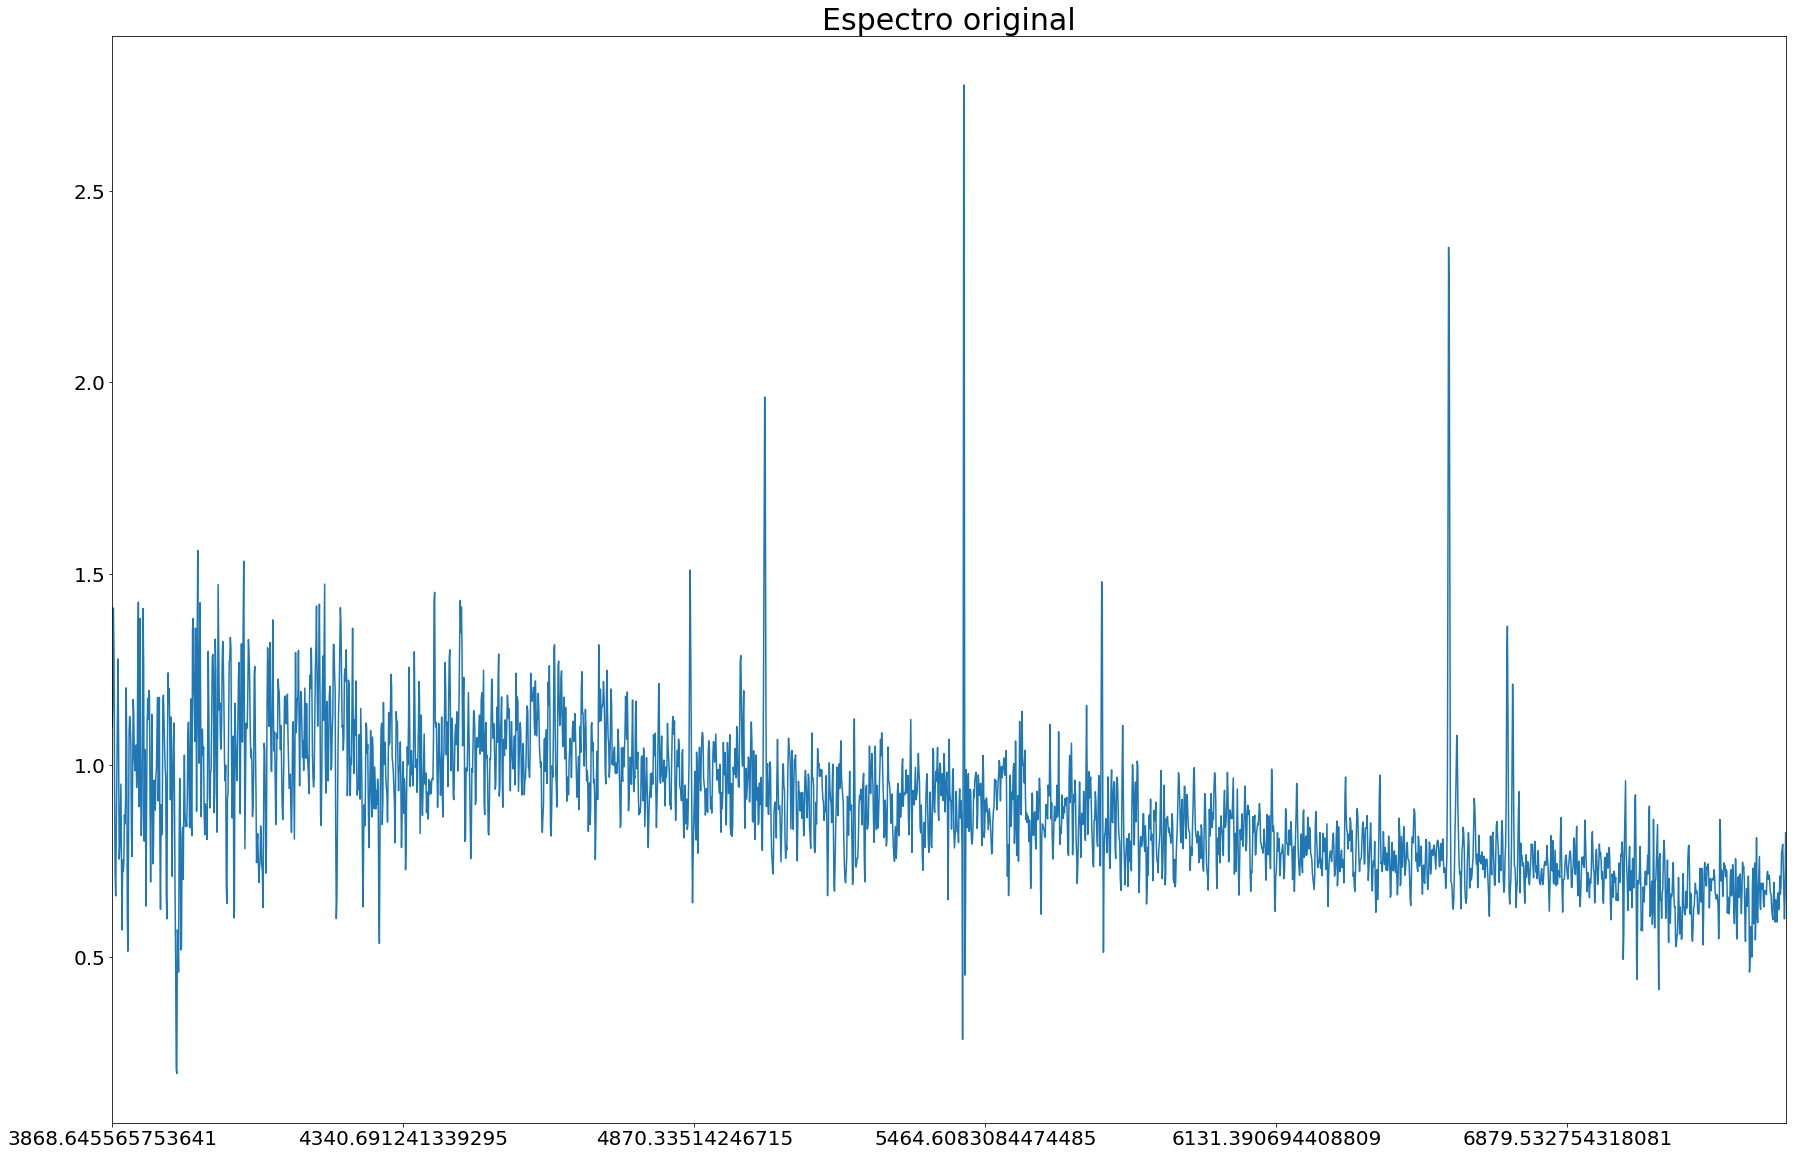

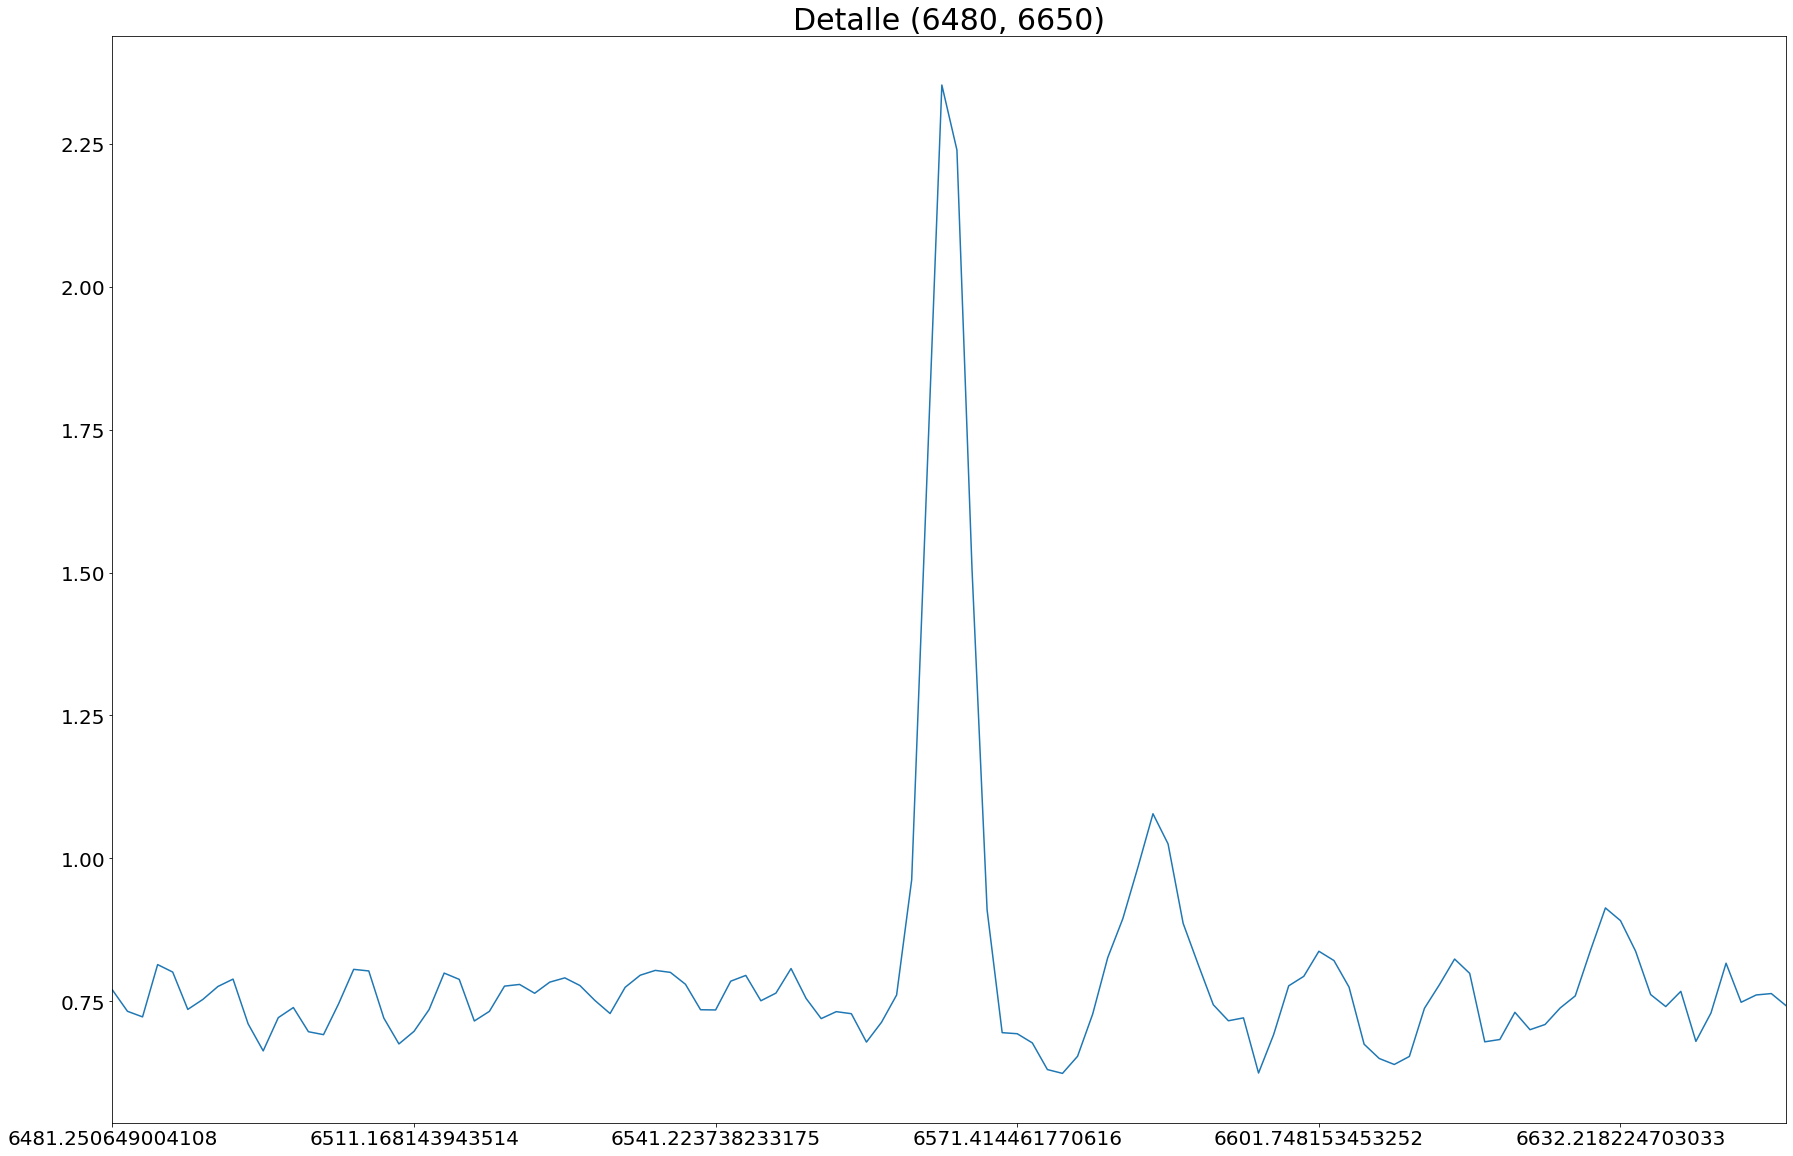

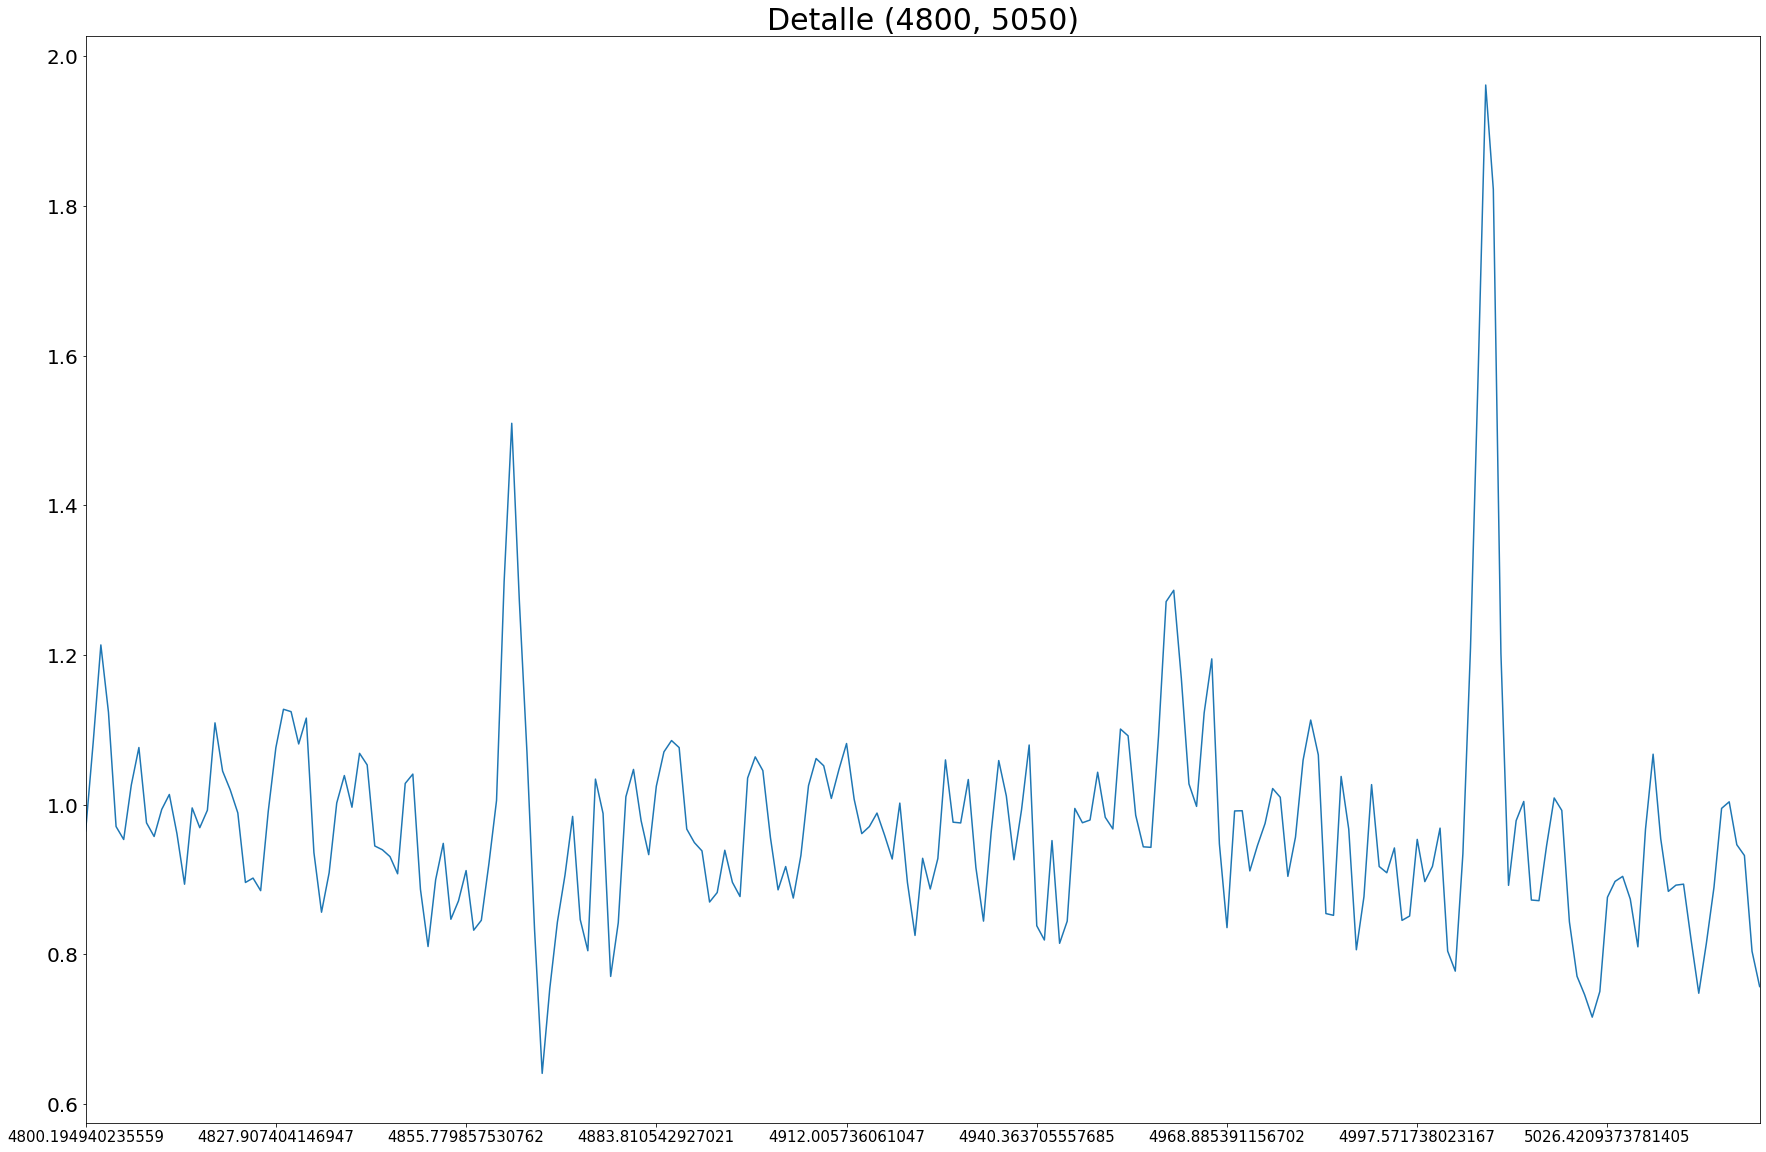

In [103]:
grafOutlier(data_origen, u_dbscan, 23, salva=True)